# Single Unit Properties at Zillow: Predicting Values and Identifying Drivers
***

## Goals

This project has three goals:

1) Create a model that will acurrately predict the values of single unit properties that the tax district assesses. 

2) Identify and report the drivers of the values of single unit properties that the tax district assesses.

3) Provide a dataframe that contains the state, county, tax rate and county tax rate of each property as well as a dataframe that reflects each county and their respective tax rate. 


In [1]:
# Establishing environment
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from env import host, user, password
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from prepare import prep_zillow_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, RFE
from acquire import get_zillow_data
from prepare import prep_zillow_data

import warnings
warnings.filterwarnings("ignore")

## Acquire
Acquire data from the customers table from the zillow database on the codeup data science database server.


We will also be taking the functions from this phase and creating an acquire.py file so our work can be easily replicated.
***

Function below creates a URL string that can be used to connect to the data science database

In [2]:
def get_connection(db, user=user, host=host, password=password):
    """
    Function creates a URL that can be used to connect to the data science database.
    """
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

The function below creates a dataframe from the zillow data by using the URL string from the first function and connecting to the zillow table in the data science database.

In [3]:
def get_zillow_data():
    """
    Function connects to the data science database and returns a data frame containing Zillow data for propertys whose last transaction was in May through June 2017.
    """
    # SQL query string
    sql_query = "SELECT * FROM properties_2017 JOIN predictions_2017 on predictions_2017.parcelid = properties_2017.parcelid WHERE unitcnt = 1 AND transactiondate BETWEEN '2017-05-01' AND '2017-06-30'"
    # creates dataframe using data from DS database
    df = pd.read_sql(sql_query, get_connection('zillow'))
    # returns DF 
    return df

We will now test our function to ensure it works.

In [12]:
# creating dataframe using data acquired from function
df = get_zillow_data()

# previewing data to ensure function operates correctly
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,parcelid,logerror,transactiondate
0,2061546,11289917,1.0,None,None,2.0,3.0,NaN,6.0,2.0,...,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,11289917,-0.362001,2017-06-23
1,1834372,11705026,NaN,None,None,1.0,2.0,NaN,6.0,1.0,...,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,11705026,-0.146056,2017-06-30
2,2121349,11389003,NaN,None,None,2.0,3.0,NaN,6.0,2.0,...,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,11389003,-0.325393,2017-06-01
3,2093710,11967869,NaN,None,None,1.0,2.0,NaN,5.0,1.0,...,2016.0,191821.0,3267.47,None,NaN,6.037185e+13,3429,11967869,-0.005566,2017-06-29
4,1288537,12035176,NaN,None,None,1.0,1.0,NaN,11.0,1.0,...,2016.0,146810.0,2926.19,None,NaN,6.037189e+13,5444,12035176,-0.114435,2017-05-24


### Acquire Takeaways

- Acquiring data from zillow database on the codeup data science database server via the __get_connection__ and __get_zillow_data__ function
- Both functions from this section are available in the __acquire.py__ file deliverable

## Prepare

Prepare, tidy, and clean the data so it can be explored and analyzed.

We will also be using the code from this phase to create an external prepare.py file that can be used to easily replicate our work.
***

In [5]:
# displaying column names and null value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13309 entries, 0 to 13308
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            13309 non-null  int64  
 1   parcelid                      13309 non-null  int64  
 2   airconditioningtypeid         6226 non-null   float64
 3   architecturalstyletypeid      0 non-null      object 
 4   basementsqft                  0 non-null      object 
 5   bathroomcnt                   13309 non-null  float64
 6   bedroomcnt                    13309 non-null  float64
 7   buildingclasstypeid           2 non-null      float64
 8   buildingqualitytypeid         13162 non-null  float64
 9   calculatedbathnbr             13296 non-null  float64
 10  decktypeid                    0 non-null      object 
 11  finishedfloor1squarefeet      0 non-null      object 
 12  calculatedfinishedsquarefeet  13308 non-null  float64
 13  f

Dropping columns that meet any of the following criterion:
* more than 2,000 null values 
* do not contain relevant data for predicting property value 
    - examples include irrelevant IDs, fips, etc.
* taxamount, structuretaxvaluedollarcnt, landtaxvaluedollarcnt 
    - per project specifications we cannot use these columns
        - "for prediction purposes, we won't know tax amount until we know tax value"
        - confirmed by Data Science senior team member John Salas

In [6]:
# .nunique shows us how many unique values are held in each column
df.nunique()

id                          13308
parcelid                    13308
airconditioningtypeid           1
architecturalstyletypeid        0
basementsqft                    0
                            ...  
censustractandblock         10177
id                          13309
parcelid                    13308
logerror                    13213
transactiondate                56
Length: 63, dtype: int64

Dropping columns that meet any of the following criterion:
- categorical columns with more than 5 unique values 
    - it will be cumbersome to create a boolean value for each
- columns with only 1 value as 
    - our model won't be able to make any meaningful distinctions with them

While viewing data in SQL we noted several columns that appear to have identical data to one another. We will confirm if this is the case.

In [7]:
# comparing each pair of columns we suspected are duplicates
# the resulting variables tell us how many rows differ between each
sqft_columns_diff = (df.finishedsquarefeet12 != df.calculatedfinishedsquarefeet).sum()
bathroom_count_diff = (df.calculatedbathnbr != df.bathroomcnt).sum()
bathroom_count_diff_alt = (df.fullbathcnt != df.bathroomcnt).sum()

print(f'Number of different values between finishedsquarefeet12 and calculatedfinishedsquarefeet: {sqft_columns_diff}')
print(f'Number of different values between calculatedbathnbr and bathroomcnt: {bathroom_count_diff}')
print(f'Number of different values between fullbathcnt and bathroomcnt: {bathroom_count_diff_alt}')

Number of different values between finishedsquarefeet12 and calculatedfinishedsquarefeet: 13
Number of different values between calculatedbathnbr and bathroomcnt: 13
Number of different values between fullbathcnt and bathroomcnt: 13


Dropping the following columns because with the exception of 13 rows, they are duplicates:
- finishedsquarefeet12 (near-duplicate of calculatedfinishedsquarefeet)
- calculatedbathnbr (near-duplicate of bathroomcnt)
- bathroomcnt (near-duplicate of bathroomcnt)

In [8]:
# Dropping columns with more than 2000 rows missing
df = df.drop(columns=['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft','yardbuildingsqft26', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear'], axis=1)

# Dropping columns with high amount of duplicate values
df = df.drop(columns=['finishedsquarefeet12', 'calculatedbathnbr', 'fullbathcnt'], axis=1)

# Dropping columns with irrelevant data
df = df.drop(columns=['id', 'fips', 'parcelid', 'latitude', 'longitude', 'rawcensustractandblock', 'censustractandblock', 'heatingorsystemtypeid', 'regionidcounty', 'logerror' ], axis=1)

# Dropping categorical columns with more than 5 unique values
df = df.drop(columns=['propertycountylandusecode', 'propertylandusetypeid','buildingqualitytypeid', 'propertyzoningdesc', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate' ], axis=1)

# Dropping columns with only 1 unique value
df = df.drop(columns=['roomcnt', 'unitcnt', 'assessmentyear'], axis=1)

# Dropping columns that are prohibited from use
df = df.drop(columns=['taxamount', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt'], axis=1)

- All columns that we specified for removal have been dropped. We'll now take another look at the data with .info for further changes needed.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13309 entries, 0 to 13308
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   13309 non-null  float64
 1   bedroomcnt                    13309 non-null  float64
 2   calculatedfinishedsquarefeet  13308 non-null  float64
 3   lotsizesquarefeet             12976 non-null  float64
 4   taxvaluedollarcnt             13309 non-null  float64
dtypes: float64(5)
memory usage: 520.0 KB


We will change the names of our remaining columns to make them easier to understand
- Rename bathroomcnt to bathroom_count
- Rename bedroomcnt to bedroom_count
- Rename calculatedfinishedsquarefeet to unit_sq_feet
- Rename lotsizesquarefeet to lot_size_sq_feet
- Rename taxvaluedollarcnt to tax_dollar_value

lotsizesquarefeet has 333 missing values
- Out of 13309 rows, this is less than 3% of the total so we'll remove them along with the one null value row from calculatedfinishedsquarefeet

Data types are all appropriate so we don't need to change them

In [64]:
# creating dataframe using data acquired from function
df = get_zillow_data()

# previewing data to ensure function operates correctly
df = df[['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'lotsizesquarefeet', 'taxvaluedollarcnt']]

df.dropna(inplace=True)

df.shape

(12975, 5)

In [77]:
df['lotsizesquarefeet'].sort_values().tail()

5687     1904165.0
12232    1904165.0
7701     1904165.0
7703     1904165.0
3397     3589145.0
Name: lotsizesquarefeet, dtype: float64

In [83]:
df.drop(df[df['lotsizesquarefeet'] > 3000000].index, inplace = True) 

df.shape

(12974, 5)

In [78]:
df['calculatedfinishedsquarefeet'].sort_values().tail()

2090    11020.0
3460    11478.0
5173    13598.0
6118    15450.0
3796    35640.0
Name: calculatedfinishedsquarefeet, dtype: float64

In [84]:
df.drop(df[df['calculatedfinishedsquarefeet'] > 35000].index, inplace = True) 

df.shape

(12973, 5)

In [79]:
df['taxvaluedollarcnt'].sort_values().tail()

1064    13852918.0
3460    15623925.0
5133    18812604.0
8452    22589311.0
3040    23858374.0
Name: taxvaluedollarcnt, dtype: float64

In [85]:
df.drop(df[df['taxvaluedollarcnt'] > 20000000].index, inplace = True) 

df.shape

(12971, 5)

In [65]:
quartiles_lotsize = np.percentile(df.lotsizesquarefeet, [25, 75])

high_outlier_lotsize = quartiles_lotsize[1] + (1.5 * (q3_lotsize[1] - q3_lotsize[0]))

df[df.lotsizesquarefeet > high_outlier_lotsize]


quartiles_lotsize

array([ 6000. , 17324.5])

In [49]:
quartiles_propsize = np.percentile(df.calculatedfinishedsquarefeet, [25, 75])

high_outlier_propsize = (1.5 * (q3_propsize[1] - q3_propsize[0]))

In [50]:
quartiles_bed = np.percentile(df.bedroomcnt, [25, 75])

high_outlier_bedroom = (1.5 * (q3_bed[1] - q3_bed[0]))

In [51]:
quartiles_bath = np.percentile(df.bathroomcnt, [25, 75])

high_outlier_bathroom = (1.5 * (q3_bath[1] - q3_bath[0]))

In [52]:
quartiles_value = np.percentile(df.taxvaluedollarcnt, [25, 75])

high_outlier_value = (1.5 * (q3_value[1] - q3_value[0]))

In [10]:
# using head to examine raw values of columns
df.head(10)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt
0,2.0,3.0,1458.0,8284.0,136104.0
1,1.0,2.0,1421.0,6707.0,35606.0
2,2.0,3.0,1650.0,7300.0,614000.0
3,1.0,2.0,693.0,2908.0,274237.0
4,1.0,1.0,812.0,93226.0,245906.0
5,2.0,3.0,1108.0,6050.0,486866.0
6,2.0,3.0,1947.0,6404.0,388478.0
7,1.0,2.0,1061.0,4800.0,31839.0
8,2.0,3.0,1632.0,6040.0,499402.0
9,3.0,3.0,2768.0,34309.0,151340.0


- No binary values
- Various units of measurement (dollars, feet, bedrooms, bathrooms)
- All columns contain numerical values

For these reasons we will need to scale all of our columns except taxvaluedollarcnt (since it's our target variable and target variables should not be scaled).

- We'll now use the function from the prepare.py file we created to prepare the data with the changes documented above so that we can continue into our explore phase.

In [2]:
# creating data frames that we'll need to progress via prep_zillow function from prepare.py file
train, y_train, y_validate, y_test, X_train_scaled, X_train, X_validate, X_test, X_validate_scaled, X_test_scaled = prep_zillow_data('taxvaluedollarcnt')

In [3]:
# sampling dataframe to confirm function ran successfully
X_train_scaled.head()

,unit_sq_feet,bedroom_count,bathroom_count,lot_size_sq_feet
0,0.050196,0.181818,0.090909,0.011535
1,0.414471,0.363636,0.454545,0.011624
2,0.137504,0.181818,0.181818,0.004423
3,0.396582,0.454545,0.545455,0.123836
4,0.166963,0.363636,0.272727,0.006861


## Prepare Takeaways

Removing columns that meet any of the following criterion:
- More than 2,000 row missing
- Duplicates or near-duplicates of other columns
- Contain data that's irrelevant to our project
- Categorical with more than 5 unique values
- Contain only 1 unique column
- Are prohibited from being used per project spefications

Rename remaining columns for readability and understanding

Chosen columns all have appropriate data types so we won't need to change them

Drop rows with missing values since this accounts for less than 3% of all rows

Scale every non-target variable column. (ie. everything except taxvaluedollarcnt)

Split all data into train, validate and test samples

All of these changes will be done via the __prep_zillow_data__ function within the __prepare.py__ file deliverable

# Explore
We will explore our prepped data to identify drivers of property value and relationships between variables.
***

We begin by creating a heatmap of that includes each of the features we retained from our prep phase:
- unit_sq_ft (formerly calculatedfinishedsquarefeet) 
- bedroom_count (formerly bedroomcnt)                    
- bathroom_count (formerly bathroomcnt)
- lot_size_sq_ft (formerly lotsizesquarefeet) 

Text(68.09375, 0.5, 'Features')

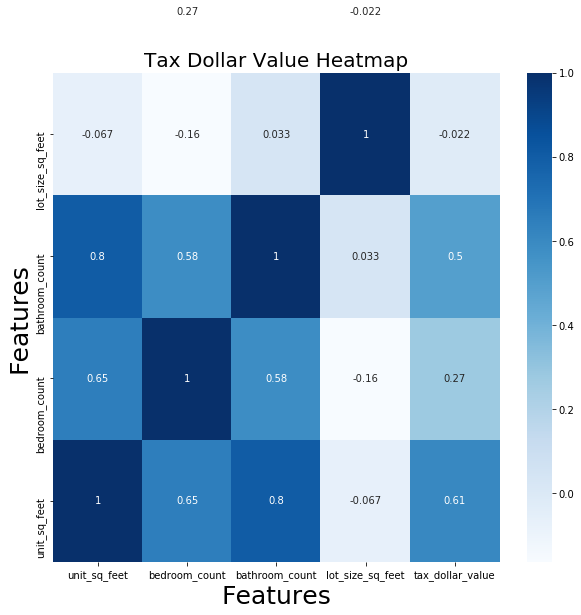

In [4]:
# creating copy of train DF to avoid altering the original
hmap_train = train.copy()

# creating scaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# fitting scaler to train data
scaler.fit(hmap_train)

# scaling train data and converting to data frame
hmap_train = pd.DataFrame(scaler.transform(hmap_train))

# renaming columns as they were erased in the DF conversion
hmap_train.rename(columns={0: 'unit_sq_feet', 1: 'bedroom_count', 2: 'bathroom_count', 3: 'lot_size_sq_feet', 4: 'tax_dollar_value' }, inplace=True)

# plotting heatmap
plt.figure(figsize=(10,9))

sns.heatmap(hmap_train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)
plt.title('Tax Dollar Value Heatmap', fontsize = 20)
plt.xlabel('Features', fontsize = 25)
plt.ylabel('Features', fontsize = 25)

- Given their strong tones and coefficients when applied to tax_dollar_value, bathroom_count, bedroom_count and unit_sq_ft all appear to be strong drivers of property value.

- Unit_sq_ft, bathroom_count, and bedroom_count also show strong correlation with one another. 
    - This may be becuase larger propertys tend to have more bathrooms and bedrooms while smaller propertys tend to have less.

- Given it's weak coloring an low coefficient, lot_size_sq_feet appears to be a weak drivr of property value.

- We will create hypothesis tests and visualizations to further explore each of these features in more depth.

## Feature: unit_sq_feet

### Initial idea: The value of a property is impacted by how large it is. 

Text(0.5, 1.0, 'Property Values Based on Property Size (Sq. Feet)')

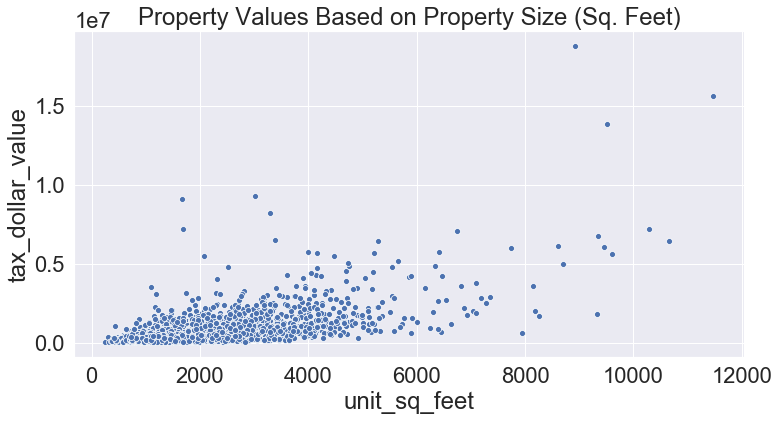

In [5]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
sns.scatterplot(x='unit_sq_feet',y='tax_dollar_value', data=train).set_title("Property Values Based on Property Size (Sq. Feet)")

- The value of a property appears to increase as the size of the property increases.
- We will perform a hypothesis test (Pearson Correlation) to confirm if there is a correlation between these values.
- This chart originally depicted several extreme outliers that had uncommonly high tax_dollar_value (over $20,000,000) or property size ( > 35,000 sqft.). We returned to prep and dropped these values as there were very few of them (< 5). 

### Test: Pearson Correlation

#### Hypothesis:
H0 = There is no linear correlation between calculated finished square feet and home value.

H1 = There is a linear correlation between calculated finished square feet and home value.

In [6]:
# declaring variables to test for correlation on
x = X_train['unit_sq_feet']
y = y_train['tax_dollar_value']

# performing pearson correlation test
r, p = stats.pearsonr(x, y)

# printing results
print(f'alpha = .05\n')
print(f'r = {r:.5f}')
print(f'p = {p:.3f}')

alpha = .05

r = 0.60722
p = 0.000


- Since p is less than alpha, we reject our null hypothesis that there is no linear relationship between calculated finished square feet and home value.

- In other words, there is evidence that the size of a property has an impact on the property's value.

## Feature: lot_size_sq_feet

### Initial idea: The value of a property is impacted bythe size of the lot it is located on. 

Text(0.5, 1.0, 'Property Values Based on Lot Size (Sq. Feet)')

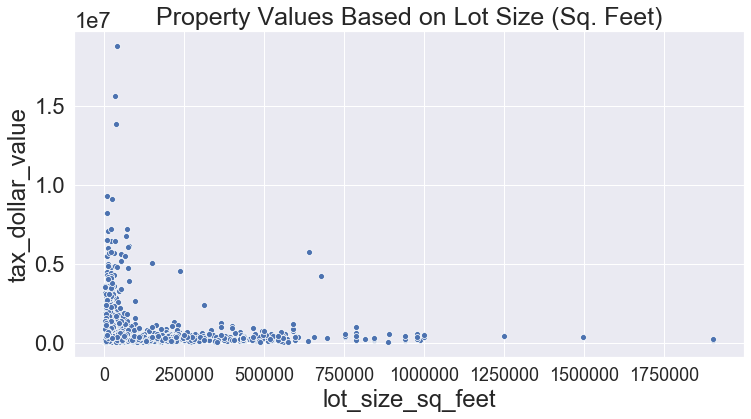

In [7]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale = 2)
plt.rc('xtick',labelsize=18)
sns.scatterplot(x='lot_size_sq_feet',y='tax_dollar_value', data=train).set_title('Property Values Based on Lot Size (Sq. Feet)', fontsize = 25)

- Most high value properties appear to have small lot sizes
    - Perhaps many of the high value properties have small lots but are very tall, thus allowing them to have high square footage with a small lot size
- We will perform a hypothesis test (Pearson Correlation) to confirm if there is a correlation between these lot size and property value.
- This chart originally depicted extreme outliers that had uncommonly high tax_dollar_value ($20,000,000) and lot_size (3,000,000 sqft.). We returned to prep and dropped these values as there were very few of them (< 5).

### Test: Pearson Correlation

#### Hypothesis:
H0 = There is no linear correlation between lot size and home value.

H1 = There is a linear correlation between lot size and home value.

In [8]:
# declaring variables to test for correlation on
x = X_train['lot_size_sq_feet']
y = y_train['tax_dollar_value']

# performing pearson correlation test
r, p = stats.pearsonr(x, y)

# printing results
print(f'alpha = .05\n')
print(f'r = {r:.5f}')
print(f'p = {p:.3f}')

alpha = .05

r = -0.02227
p = 0.058


- Since p is less than alpha, we reject our null hypothesis that there is no linear correlation between bathroom count and home value.

- In other words, there is evidence that the size of the lot a property is located on has an impact on the property's value.

## Feature: bathroom_count 

### Initial idea: The value of a unit will increase if it has more than the average number of bathrooms. 

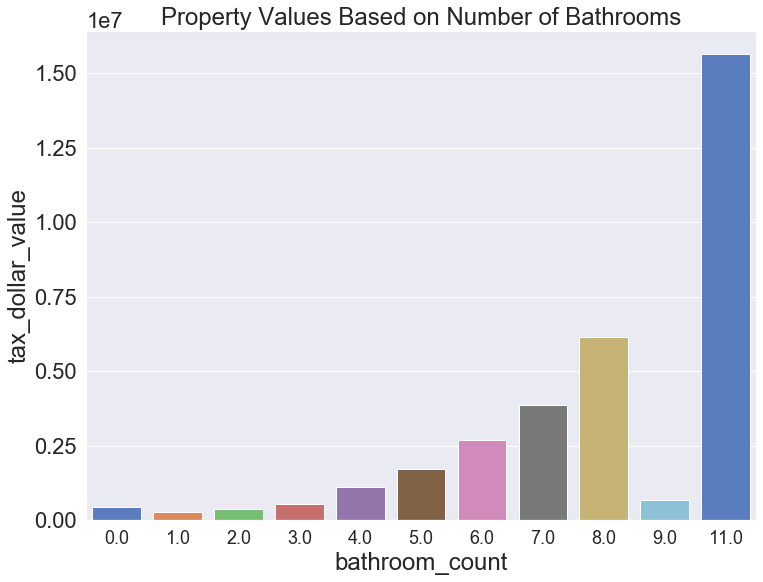

In [9]:
plt.figure(figsize=(12,9))
sns.barplot(x='bathroom_count',y='tax_dollar_value', data=train, ci=None, palette=('muted')).set_title("Property Values Based on Number of Bathrooms")
sns.set(font_scale = 3)

- Generally, property value appears to increase as the the number of bathrooms increase
- We will calculate the average number of bathrooms per property and then formulate a hypothesis using this data.

### Test: T-Test

In [10]:
# calculating average number of bathrooms per property
avg_bathroom_count = round((train.bathroom_count).mean())

print(f'The average number of bathrooms in a property is {avg_bathroom_count}.\n')
print(f'We will formulate our hypothesis on the grounds that a property has more than the average number of bathrooms if it has 3 or more.')

The average number of bathrooms in a property is 2.

We will formulate our hypothesis on the grounds that a property has more than the average number of bathrooms if it has 3 or more.


#### Hypothesis:
H0 - The value of units with 3 or more bathrooms is equal to or less than the value of units with 2 or less bathrooms

H1 - The value of units with 3 or more bathrooms is greater than the value of units with 2 or less bathrooms.

In [11]:
# x1 = df of data for propertiess with 3 or more bathrooms
# x2 = df of data for properties with 2 or less bathrooms
x1 = train[train.bathroom_count > 2].tax_dollar_value
x2 = train[train.bathroom_count <= 2].tax_dollar_value

# performing t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = 26.22647
p = 3.1504029351406514e-145


- Since p is less than alpha and t is greater than 0, we reject our null hypothesis that the value of units with 3 or more bathrooms is equal to or less than the value of units with 2 or less bathrooms.

- In other words, there is evidence that bathroom_count is a positive driver of property value.

## Feature: bedroom_count

### Initial idea: The value of a unit will increase if it has more than the average number of bedrooms. 

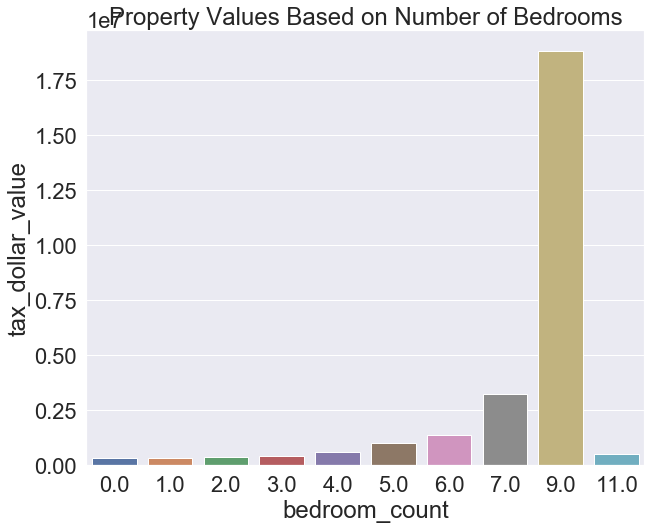

In [31]:
plt.figure(figsize=(10,8))
sns.barplot(x='bedroom_count',y='tax_dollar_value', data=train, ci=None).set_title("Property Values Based on Number of Bedrooms")
sns.set(font_scale = 2)

- Generally, property value appears to increase as the the number of bedrooms increase
- We will calculate the average number of bedrooms per property and then formulate a hypothesis using this data.

### Test: T-Test

In [13]:
# calculating average number of bedrooms per property
avg_bedroom_count = round((train.bedroom_count).mean())

print(f'The average number of bedrooms in a property is {avg_bedroom_count}.\n')
print(f'We will formulate our hypothesis on the grounds that a property has more than the average number of bedrooms if it has 4 or more.')

The average number of bedrooms in a property is 3.

We will formulate our hypothesis on the grounds that a property has more than the average number of bedrooms if it has 4 or more.


#### Hypothesis:

H0 - The value of units with 4 or more bedrooms is equal to or less than the value of units with 3 or less bedrooms. 

H1 - The value of units with 4 or more bedrooms is greater than the value of units with less 3 or less bedrooms.

In [14]:
# x1 = df of data for propertys with 4 or more bedrooms
# x2 = df of data for propertys with 2 or less bedrooms
x1 = train[train.bedroom_count > 3].tax_dollar_value
x2 = train[train.bedroom_count <= 3].tax_dollar_value

# performing ttest
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = 20.20755
p = 1.0935416925453028e-88


- Since p is less than alpha and t is greater than 0, we reject our null hypothesis that the value of units with 3 or more bedrooms is equal to or less than the value of units with 2 or less bedrooms.

- In other words, there is evidence that bedroom_count is a positive driver of property value.

### Exploration Takeaways

- Heatmap of all features shows the following features are strongly correlated with property value:
    - bathroom_count
    - bedroom_count
    - unit_sq_ft
    
    
- Although lot_size_sq_ft, may not have as strong of a correlation with property value, we will still create a model with it to observe its effectiveness as a predictive feature.


- T-Tests suggest that having more than the average number of bathrooms or bedrooms in a property increases its value


- Pearson Correlation tests suggest that the size of a property and the lot it's located on have an impact on its value

# Modeling
We use these variables that we believe strongly correlate with churn to create a model that will allow us to predict churn
***

## Baseline
We'll now construct a baseline and gauge its accuracy to determine what accuracy an alternate model would need in order to be viable.

In [15]:
# making a copy of train data so we can add a baseline column without changing original train DF
y_train_bl = y_train.copy()

# adding baseline_prediction column that holds the mean of property tax values
y_train_bl['baseline_prediction'] = y_train['tax_dollar_value'].mean()

y_train_bl.head()

,tax_dollar_value,baseline_prediction
9233,84251.0,476756.842902
6574,1770641.0,476756.842902
3647,116532.0,476756.842902
2623,4548320.0,476756.842902
6727,125644.0,476756.842902


In [16]:
RMSE_bl = np.sqrt(mean_squared_error(y_train.tax_dollar_value, y_train_bl.baseline_prediction))
print("Baseline Root mean squared error: {:.100}".format(round(RMSE_bl)))

Baseline Root mean squared error: 665792.0


- Our baseline's RMSE value is 698,688. We'll need to construct at least one model that can attain a RMSE value lower than this.

## Feature Engineering
We'll be using Recursive Feature Elimination to rank each of our features in terms of their viability in predicting property value.

In [17]:
# creating linear regression object
lm = LinearRegression()

# creating RFE object that will use our linear regression object and only pick only the single best feature
rfe = RFE(lm, 1)

# transforming data using rfe object
x_rfe = rfe.fit_transform(X_train, y_train)

# fitting our linear regression model to data
lm.fit(X_train, y_train)

# storing array of boolean values that reflect true if a feature was one of the three selected
# false otherwise
mask = rfe.support_

# creating list of the top feature using boolean mask
rfe_features = X_train.loc[:,mask].columns.tolist()

# creating array of ranking list
var_ranks = rfe.ranking_

# creating list of feature names
var_names = X_train_scaled.columns.tolist()

# combine ranks and names into a df
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

# sort the df by rank
rfe_ranks_df.sort_values('Rank')

,Var,Rank
2,bathroom_count,1
1,bedroom_count,2
0,unit_sq_feet,3
3,lot_size_sq_feet,4


- RFE shows that bathroom_count is the most useful feature for predicting property value.
- bedroom_count is second
- unit_sq_feet is third
- lot_size_sq_feet is last

## Non-Baseline Models (Training)

### Name: Model 1

Type: Linear Regression Model

Features:
- bathroom_count
- bedroom_count
- unit_sq_feet
- lot_size_sq_feet

Detail: None

In [18]:
# copying df to avoid changing original when we add predictions column
y_train_m1 = y_train.copy()

# creating linear regression object
lm_1 = LinearRegression()

# fitting model to data
lm_1.fit(X_train_scaled, y_train_m1)

# adding column to model 1 train that holds model 1 predictions of property value
y_train_m1['model_1_prediction'] = lm_1.predict(X_train_scaled)

# calculating RMSE value of model 1 on train data
RMSE_lm_m1 = round(np.sqrt(mean_squared_error(y_train.tax_dollar_value, y_train_m1.model_1_prediction)))

# printing results
print(f'Model 1s RMSE value when predicting property values on the train data set is {RMSE_lm_m1}')

Model 1s RMSE value when predicting property values on the train data set is 517344.0


### Name: Model 2

Type: Linear Regression Model

Features:
- bathroom_count
- bedroom_count
- unit_sq_feet

Detail: Removing least most important feature according to RFE ranking (lot_size_sq_feet)

In [19]:
# copying df to avoid changing original when we add predictions column
y_train_m2 = y_train.copy()

# creating linear regression object
lm_2 = LinearRegression()

# fitting model to data
lm_2.fit(X_train_scaled[['bathroom_count', 'bedroom_count', 'unit_sq_feet']], y_train_m2)

# adding column to model 2 train that holds model 2 predictions of property value
y_train_m2['model_1_prediction'] = lm_2.predict(X_train_scaled[['bathroom_count', 'bedroom_count', 'unit_sq_feet']])

# calculating RMSE value of model 2 on train data
RMSE_lm_m2 = round(np.sqrt(mean_squared_error(y_train.tax_dollar_value, y_train_m2.model_1_prediction)))

# printing results
print(f'Model 2s RMSE value when predicting property values on the train data set is {RMSE_lm_m2}')

Model 2s RMSE value when predicting property values on the train data set is 517423.0


### Name: Model 3

Type: Linear Regression Model

Features:
- bathroom_count
- bedroom_count

Detail: Removing 2 least most important features according to RFE ranking (lot_size_sq_feet and unit_sq_feet)

In [20]:
# copying df to avoid changing original when we add predictions column
y_train_m3 = y_train.copy()

# creating linear regression object
lm_3 = LinearRegression()

# fitting model to data
lm_3.fit(X_train_scaled[['bathroom_count', 'bedroom_count']], y_train_m3)

# adding column to model 3 train that holds model 3 predictions of property value
y_train_m3['model_1_prediction'] = lm_3.predict(X_train_scaled[['bathroom_count', 'bedroom_count']])

# calculating RMSE value of model 3 on train data
RMSE_lm_m3 = round(np.sqrt(mean_squared_error(y_train.tax_dollar_value, y_train_m3.model_1_prediction)))

# printing results
print(f'Model 3s RMSE value when predicting property values on the train data set is {RMSE_lm_m3}')

Model 3s RMSE value when predicting property values on the train data set is 577808.0


- Baseline RMSE: 698688

- Model 1 RMSE: 551421

- Model 2 RMSE: 551490

- Model 3 RMSE: 622158

- Models 1 and 2 had the best (lowest) RMSE values so we will be using them to predict values in the validate sample.

## Non-Baseline Models (Validation)

In [21]:
# creating copy of y_validate DF to avoid altering the original when we add our predictions column
y_validate_m1 = y_validate.copy()

# adding column to model 1 train that holds model 1 predictions of property value
y_validate_m1['model_1_prediction'] = lm_1.predict(X_validate_scaled)

# calculating RMSE value of model 1 on validate data
RMSE_lm_m1_val = round(np.sqrt(mean_squared_error(y_validate.tax_dollar_value, y_validate_m1.model_1_prediction)))

# printing results
print(f'Model 1s RMSE value when predicting property values on the train data set is {RMSE_lm_m1_val}')

Model 1s RMSE value when predicting property values on the train data set is 530223.0


In [22]:
# creating copy of y_validate DF to avoid altering the original when we add our predictions column
y_validate_m2 = y_validate.copy()

# adding column to model 2 train that holds model 2 predictions of property value
y_validate_m2['model_2_prediction'] = lm_2.predict(X_validate_scaled[['bathroom_count', 'bedroom_count', 'unit_sq_feet']])

# calculating RMSE value of model 2 on validate data
RMSE_lm_m2_val = round(np.sqrt(mean_squared_error(y_validate.tax_dollar_value, y_validate_m2.model_2_prediction)))

# printing results
print(f'Model 2s RMSE value when predicting property values on the train data set is {RMSE_lm_m2_val}')

Model 2s RMSE value when predicting property values on the train data set is 530503.0


- Model 1 RMSE: 674204

- Model 2 RMSE: 674829

- Models 1 had the best (lowest) RMSE value so we will be using it to predict values in the test sample.

## Non-Baseline Model (Test)

In [23]:
# creating copy of y_test DF to avoid altering the original when we add our predictions column
y_test_m1 = y_test.copy()

# adding column to model 1 train that holds model 1 predictions of property value
y_test_m1['model_1_prediction'] = lm_1.predict(X_test_scaled)

# calculating RMSE value of model 1 on validate data
RMSE_lm_m1_test = round(np.sqrt(mean_squared_error(y_test.tax_dollar_value, y_test_m1.model_1_prediction)))

# printing results
print(f'Model 1s RMSE value when predicting property values on the train data set is {RMSE_lm_m1_test}')

Model 1s RMSE value when predicting property values on the train data set is 457934.0


- Model 1 RMSE value (Train): 551421
- Model 1 RMSE value (Validate): 674204
- Model 1 RMSE value (Test): 558304

## Modeling Takeaways   
- Model 1's performance (RMSE value) on the test data set was much better than its performance on the validation data set and very close to its performance on the train data set.


- Since Model 1's performance on all 3 datasets is superior to the baseline's performance, it is safe to say that that model 1 should be used instead of the baseline to predict property values.


- Model 1 used all 4 of our features from our exploration phase and performed better than any model that used less features. 
    - This is further evidence that each of those features (bathroom_count, bedroom_count, unit_sq_feet, lot_size_sq_feet) are drivers of property value.

# Overall Conclusion and Takeaways

Through exploration we discovered that drivers of property value include bathroom_count, bedroom_count, unit_sq_feet, and lot_size_sq_fee.
- Although lot_size was thought to possibly be a weak driver initially, our models performed worse without it.
    - Similarly, our hypothesis test showed lot_size_sq_feet has a linear relationship with property value (tax_dollar_value).

Recursive Feature Elimination ranked the importance of each feature in predicting value as follows:

    1)bathroom_count
    2)bedroom_count
    3)unit_sq_feet
    4)lot_size_sq_feet

Recommendations
- When assessing the value of properties, we should focus our attention on these drivers to help improve the accuracy of our value assessments.
- We should also display these features more prominently in our search result thumbnails as currently the font is relatively small.

We've created a linear regression model that uses these variables to predict property values.
- The model outperformed a baseline model that constantly predicts the mean value of homes
- The model's RMSE value on all data sets was consistently lower than all of its competitors 
- In one instance, the model only performed nearly as well on data it had never seen before (test) than it did on the data it was trained on (train). 

In the future
- We'd like to collect a wider range of data since many of the features in our dataset contained a high amount of null values and had to be excluded from our project.
    - With more features available, we may be able to incorporate new ones that improve our model's ability to make accurate predictions on property values.